In [ ]:
from stVAT import *
import pandas as pd
import anndata as ad
import numpy as np
import scanpy as sc
import torch
import scipy 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)
random.seed(42)
file_path = "D:/MeringueDATA/giotto/"
# (279, 15666)
adata = sc.read_visium('/root/stEnTrans-main/data/Human_Breast_Cancer')
adata.var_names_make_unique()

sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)

train_adata=adata[:,adata.var["n_cells_by_counts"]>len(adata.obs.index)*0.1]
train_counts=np.array(train_adata.X.todense())
train_coords=train_adata.obs[['array_row','array_col']]


test_adata = sc.read_visium('/root/stEnTrans-main/data/Human_Invasive_Ductal_Carcinoma')
test_adata.var_names_make_unique()
integral_coords= test_adata.obs[['array_row','array_col']]

sc.pp.calculate_qc_metrics(test_adata, inplace=True)
sc.pp.filter_cells(test_adata, min_genes=200)
sc.pp.filter_genes(test_adata, min_cells=10)

test_counts=np.array(test_adata.X.todense())
test_coords=test_adata.obs[['array_row','array_col']]
position_info = get_10X_position_info(integral_coords)

train_lr,train_hr,in_tissue_matrix = get10Xtrainset(train_counts, train_coords)
in_tissue_matrix = torch.Tensor(in_tissue_matrix).to(device)

test_3D_data = get10Xtestset(test_counts, test_coords)
imputed_adata = stEnTrans(adata, test_3D_data, integral_coords, position_info, train_lr, train_hr, in_tissue_matrix,  test_adata,patch_size=8, num_heads=8,epoch=2,vae_hidden_dim=128, vae_latent_dim=64,input_dim=1280)

imputed_adata.X[imputed_adata.X < 0] = 0
original_adata = test_adata.copy()
# 确保 imputed_adata.X 是密集矩阵
if isinstance(imputed_adata.X, scipy.sparse.csr_matrix):
    imputed_adata.X = imputed_adata.X.toarray()

# 确保 original_adata.X 是密集矩阵
if isinstance(original_adata.X, scipy.sparse.csr_matrix):
    original_adata.X = original_adata.X.toarray()

# 然后进行赋值操作
for idx in original_adata.obs.index:
    if idx in imputed_adata.obs.index:
        imputed_adata.X[imputed_adata.obs.index.get_loc(idx)] = original_adata.X[original_adata.obs.index.get_loc(idx)]

# 保存基因表达数据
imputed_expression = pd.DataFrame(imputed_adata.X, index=imputed_adata.obs_names, columns=imputed_adata.var_names)
# 打印前五行和前五列
print(imputed_expression.iloc[:5, :5])
imputed_expression.to_csv('IDC3.24imputed_gene_expression.csv')

# 保存插补后的数据点
imputed_coords = imputed_adata.obs[['array_row', 'array_col']]
imputed_coords.to_csv('IDC3.24imputed_spatial_positions.csv')

In [1]:
from stVAT import *
import pandas as pd
import anndata as ad
import numpy as np
import scanpy as sc
import torch
import scipy 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)
random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [2]:
adata = sc.read_visium('/root/stVAT/data/Human_Breast_Cancer')
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)
train_adata=adata[:,adata.var["n_cells_by_counts"]>len(adata.obs.index)*0.1]
train_counts=np.array(train_adata.X.todense())
train_coords=train_adata.obs[['array_row','array_col']]

In [3]:
test_adata = sc.read_visium('/root/stVAT/data/Human_Invasive_Ductal_Carcinoma')
test_adata.var_names_make_unique()
integral_coords= test_adata.obs[['array_row','array_col']]
sc.pp.calculate_qc_metrics(test_adata, inplace=True)
sc.pp.filter_cells(test_adata, min_genes=200)
sc.pp.filter_genes(test_adata, min_cells=10)
test_counts=np.array(test_adata.X.todense())
test_coords=test_adata.obs[['array_row','array_col']]
position_info = get_10X_position_info(integral_coords)
train_lr,train_hr,in_tissue_matrix = get10Xtrainset(train_counts, train_coords)
in_tissue_matrix = torch.Tensor(in_tissue_matrix).to(device)
test_3D_data = get10Xtestset(test_counts, test_coords)

In [4]:
imputed_adata = stVAT(adata=adata, test_3D_data=test_3D_data, integral_coords=integral_coords, position_info=position_info, train_lr=train_lr, train_hr=train_hr, in_tissue_matrix=in_tissue_matrix, test_adata=test_adata, patch_size=8, num_heads=4, epoch=500, input_dim=1280)

imputed_img shape: (17849, 152, 130)
Total spots: 19760
Accurate valid rows: 18378
Final flag value: 18378
Length of imputed_counts: 18378
Length of imputed_coords: 18378
Length of imputed_barcodes: 18378


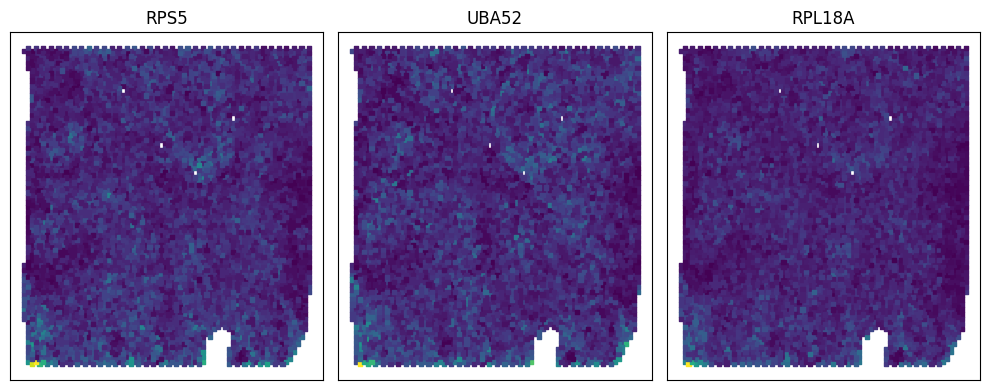

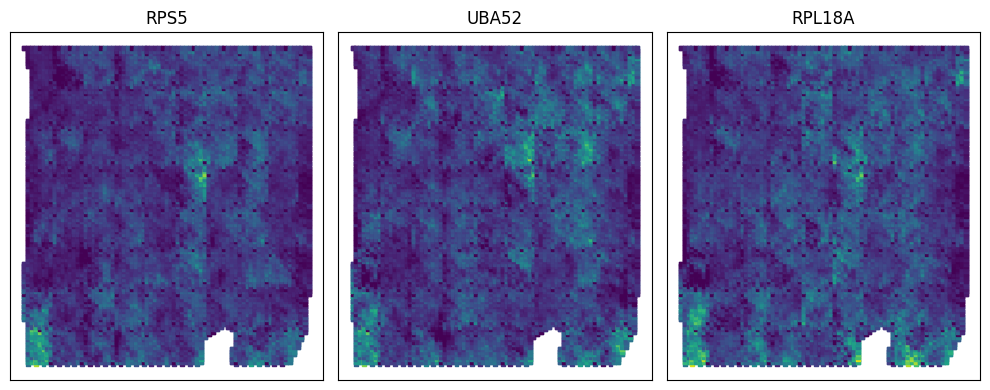

In [5]:
show_genes=['RPS5','UBA52','RPL18A']
plot_genes(test_adata, show_genes, n=3, size=(10,4),point_size=9)
plot_genes(imputed_adata, show_genes, n=3, size=(10,4),point_size=8)